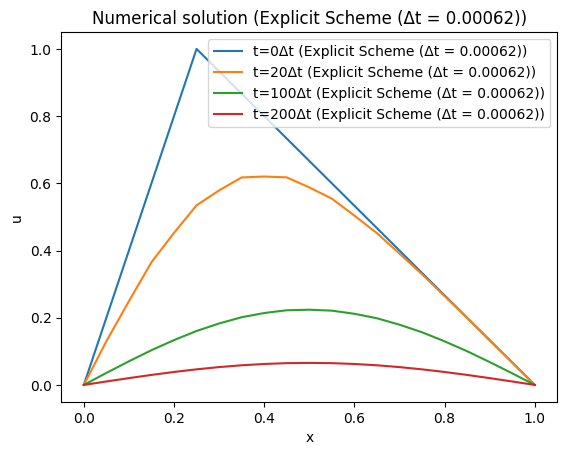

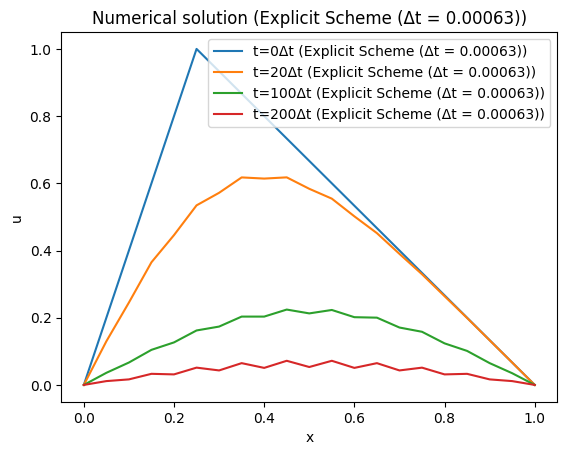

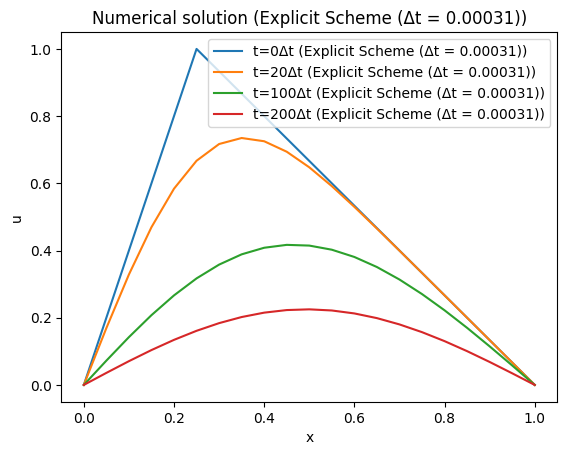

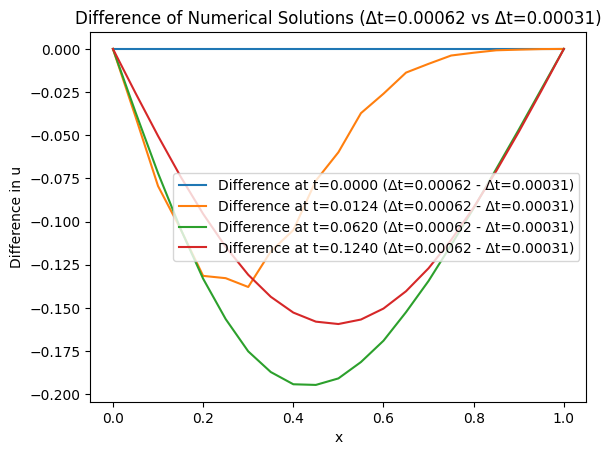

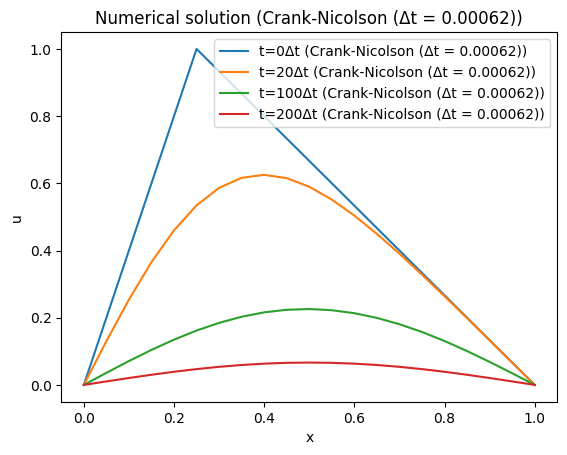

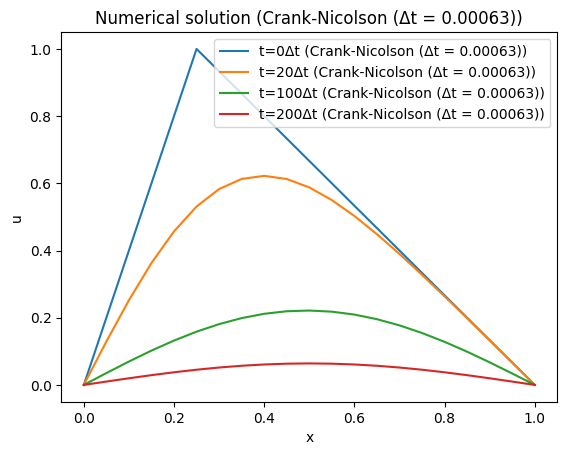

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 初始条件函数
def initial_condition(x):
    return np.where(x <= 0.25, 4*x, 4/3*(1 - x))

# 显式差分法
def explicit_scheme(a, dx, dt, J, N_steps):
    mu = dt / dx**2
    U = np.zeros((N_steps + 1, J + 1))
    x = np.linspace(0, 1, J + 1)
    U[0, :] = initial_condition(x)
    
    for n in range(N_steps):
        U[n + 1, 1:-1] = U[n, 1:-1] + a * mu * (U[n, 2:] - 2 * U[n, 1:-1] + U[n, :-2])
    return x, U

# 绘图函数
def plot_solution(x, U, dt, label):
    time_indices = [0, 20, 100, 200]
    for idx in time_indices:
        plt.plot(x, U[idx, :], label=f't={idx}Δt ({label})')
    plt.xlabel('x')
    plt.ylabel('u')
    plt.title(f'Numerical solution ({label})')
    plt.legend()
    plt.show()

# Crank-Nicolson方法
def crank_nicolson(a, dx, dt, J, N_steps):
    # 计算mu
    mu = a * dt / (2 * dx**2)
    
    # 初始化温度矩阵U，空间网格x
    U = np.zeros((N_steps + 1, J + 1))
    x = np.linspace(0, 1, J + 1)
    U[0, :] = initial_condition(x)
    
    # 构建Crank-Nicolson的系数矩阵
    # 三对角矩阵的系数
    alpha = 1 + 2 * mu
    beta = -mu
    gamma = -mu

    # 迭代求解
    for n in range(N_steps):
        # 设置右侧的已知项b
        b = U[n, 1:-1] + mu * (U[n, 2:] - 2 * U[n, 1:-1] + U[n, :-2])

        # Thomas算法所需的三对角矩阵系数
        a_diag = np.full(J - 1, alpha)
        b_diag = np.full(J - 2, beta)
        c_diag = np.full(J - 2, gamma)
        
        # 前向消元
        for i in range(1, J - 1):
            m = b_diag[i - 1] / a_diag[i - 1]
            a_diag[i] -= m * c_diag[i - 1]
            b[i] -= m * b[i - 1]
        
        # 回代
        u_new = np.zeros(J + 1)
        u_new[J - 1] = b[J - 2] / a_diag[J - 2]
        for i in range(J - 3, -1, -1):
            u_new[i + 1] = (b[i] - c_diag[i] * u_new[i + 2]) / a_diag[i]
        
        # 更新温度场
        U[n + 1, :] = u_new
    
    return x, U

# 参数设置
J, dx, a, N_steps = 20, 1 / 20, 2, 200
dt_values = [0.00062, 0.00063, 0.00031]

# 显式差分法计算与绘图
for dt in dt_values:
    x, U = explicit_scheme(a, dx, dt, J, N_steps)
    plot_solution(x, U, dt, f'Explicit Scheme (Δt = {dt})')

# 绘图函数
def plot_differences(x, U1, U2, time_indices, dt1, dt2):
    for idx in time_indices:
        diff = U1[idx, :] - U2[idx, :]
        plt.plot(x, diff, label=f'Difference at t={idx * dt1:.4f} (Δt={dt1} - Δt={dt2})')
    plt.xlabel('x')
    plt.ylabel('Difference in u')
    plt.legend()
    plt.title(f'Difference of Numerical Solutions (Δt={dt1} vs Δt={dt2})')
    plt.show()

dt_values = [0.00062, 0.00031]
# 计算并绘制数值解差异
def compute_and_plot_differences(dt_values, a, dx, J, N_steps):
    # 计算并存储不同Δt值的数值解
    solutions_explicit = []
    
    for dt in dt_values:
        # 使用显式差分法计算数值解
        x, U_explicit = explicit_scheme(a, dx, dt, J, N_steps)
        solutions_explicit.append((x, U_explicit))
    
    # 选择时间点：t = 0, 20∆t, 100∆t, 200∆t
    time_indices = [0, 20, 100, 200]
    
    # 绘制不同Δt值之间的差异
    for i in range(len(dt_values)):
        for j in range(i + 1, len(dt_values)):
            x, U1 = solutions_explicit[i]
            x, U2 = solutions_explicit[j]
            plot_differences(x, U1, U2, time_indices, dt_values[i], dt_values[j])

# 计算并绘制解差异
compute_and_plot_differences(dt_values, a, dx, J, N_steps)

dt_values = [0.00062, 0.00063]
# Crank-Nicolson方法计算与绘图
for dt in dt_values:
    x, U = crank_nicolson(a, dx, dt, J, N_steps)
    plot_solution(x, U, dt, f'Crank-Nicolson (Δt = {dt})')

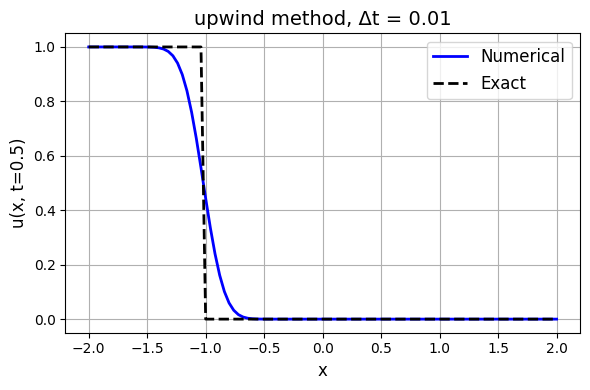

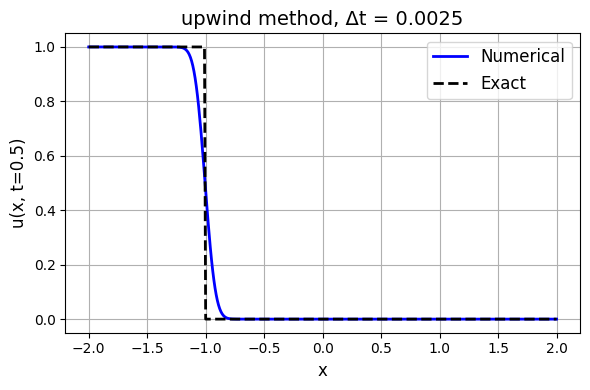

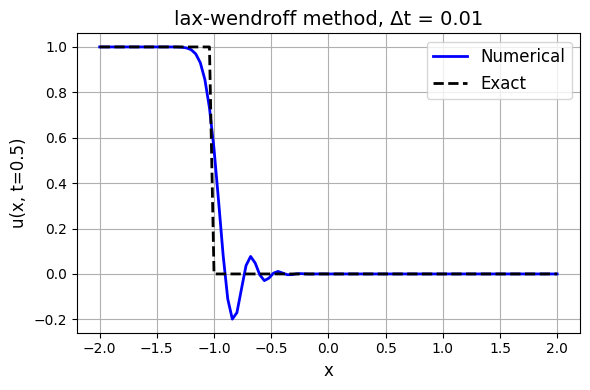

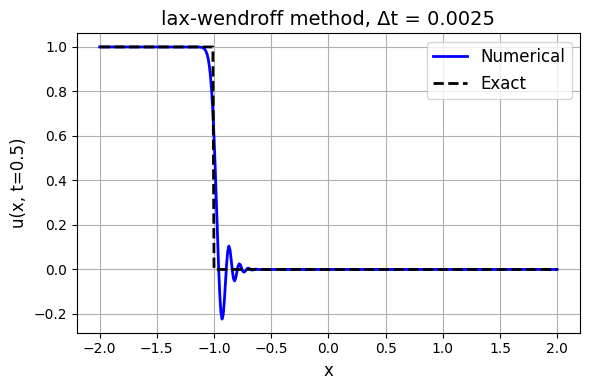

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# 精确解函数
def exact_solution(x, t):
    return np.where(x < -2 * t, 1.0, 0.0)

# Upwind 方法
def upwind(U, alpha):
    U_new = U.copy()
    U_new[1:-1] = U[1:-1] - alpha * (U[2:] - U[1:-1])
    return U_new

# Lax-Wendroff 方法
def lax_wendroff(U, alpha):
    U_new = U.copy()
    U_new[1:-1] = (
        U[1:-1]
        - 0.5 * alpha * (U[2:] - U[:-2])
        + 0.5 * alpha**2 * (U[2:] - 2 * U[1:-1] + U[:-2])
    )
    return U_new

# 主函数
def solve(method, dt, T=0.5):
    a = -2.0
    nu = 0.25
    dx = dt / nu
    x = np.arange(-2, 2 + dx, dx)
    Nt = int(T / dt)
    alpha = a * dt / dx

    U = np.where(x <= 0, 1.0, 0.0)

    for _ in range(Nt):
        U[0] = 1.0
        U[-1] = 0.0
        if method == "upwind":
            U = upwind(U, alpha)
        elif method == "lax-wendroff":
            U = lax_wendroff(U, alpha)
        U[0] = 1.0
        U[-1] = 0.0

    return x, U, exact_solution(x, T)

# 设置画图样式
for method in ["upwind", "lax-wendroff"]:
    for dt in [0.01, 0.0025]:
        x, U_num, U_ex = solve(method, dt)
        
        # 绘制图形
        plt.figure(figsize=(6, 4))
        plt.plot(x, U_num, color='b', label='Numerical', linewidth=2)
        plt.plot(x, U_ex, color='k', linestyle='--', label='Exact', linewidth=2)
        
        # 添加标题和标签
        plt.title(f"{method} method, Δt = {dt}", fontsize=14)
        plt.xlabel("x", fontsize=12)
        plt.ylabel("u(x, t=0.5)", fontsize=12)
        
        # 显示网格和图例
        plt.grid(True)
        plt.legend(loc='best', fontsize=12)
        
        # 调整布局
        plt.tight_layout()
        
        # 显示图形
        plt.show()